In [1]:
from session_factory import new_session
from PIL import Image, ImageOps
from PIL.Image import Image as PILImage

s = new_session('silueta')
s.inner_session

C:\Users\yafex\AppData\Roaming\Python\Python312\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# from pymatting.alpha.estimate_alpha_cf import estimate_alpha_cf
# from pymatting.foreground.estimate_foreground_ml import estimate_foreground_ml
# from pymatting.util.util import stack_images
# from scipy.ndimage import binary_erosion

# def alpha_matting_cutout(
#     img: PILImage,
#     mask: PILImage,
#     foreground_threshold: int=230,
#     background_threshold: int=20,
#     erode_structure_size: int=11,
# ) -> PILImage:
#     if img.mode == "RGBA" or img.mode == "CMYK":
#         img = img.convert("RGB")

#     img = np.array(img)
#     mask = np.array(mask)

#     structure = None
#     if erode_structure_size > 0:  
#         # size of the erosion structure to be applied to the mask
#         structure = np.ones((erode_structure_size, erode_structure_size), dtype=np.uint8)

#     is_foreground = binary_erosion(mask > foreground_threshold, structure=structure)
#     is_background = binary_erosion(mask < background_threshold, structure=structure, border_value=1)

#     trimap = np.full(mask.shape, dtype=np.uint8, fill_value=128)
#     trimap[is_foreground], trimap[is_background] = 255, 0

#     img_normalized = img / 255.0
#     trimap_normalized = trimap / 255.0

#     alpha = estimate_alpha_cf(img_normalized, trimap_normalized)
#     foreground = estimate_foreground_ml(img_normalized, alpha)
#     cutout = stack_images(foreground, alpha)

#     cutout = np.clip(cutout * 255, 0, 255).astype(np.uint8)
#     return Image.fromarray(cutout)

def generate_grids(w, h, tile_size=10):
    # Create a white-gray grid for the background
    grid_color = np.array([185, 185, 185], dtype=np.uint8)  # RGB for a light gray color
    grid = np.ones((h, w, 3), dtype=np.uint8) * 255
    # Size of the squares in the grid
    for y in range(0, grid.shape[0], tile_size):
        for x in range(0, grid.shape[1], tile_size):
            if (x + y) // tile_size % 2 == 0:
                grid[y:y+tile_size, x:x+tile_size] = grid_color
    return grid

def threshold_cutout(img, mask, threshold=100, show_grid=False, new_bg=None):
    mask_array = np.array(mask)
    img_array = np.array(img)
    print(img_array.shape)

    if show_grid:
        # Apply the mask to the image
        # Where the mask is True, keep the original image, otherwise use the grid background
        grid = generate_grids(img.size[0], img.size[1], tile_size=img.size[0]//20)
        result_array = np.where(mask_array[:, :, None]>threshold, img_array, grid).astype(np.uint8)
    elif new_bg:
        result_array = np.where(mask_array[:, :, None]>threshold, img_array, new_bg).astype(np.uint8)
    else:
        result_array = stack_images(img_array, mask_array)

    return Image.fromarray(result_array)

def display_transparancy(img, mask):
    # Convert mask to a boolean array
    cut_img = threshold_cutout(img, mask, show_grid=True)
    # plt.figure()
    fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
    ax[0].imshow(img)
    ax[0].axis('off')# Hide the axis
    ax[0].set_title('origin')

    ax[1].imshow(mask)
    ax[1].axis('off')# Hide the axis
    ax[1].set_title('mask')

    ax[2].imshow(cut_img)
    ax[2].axis('off')# Hide the axis
    ax[2].set_title('result')
    plt.show()
    return 0

In [3]:
grid = generate_grids(768, 768)
grid.shape

(768, 768, 3)

In [4]:
from PIL import Image
img = Image.fromarray(grid)
img.save('grids.jpg')

(1792, 1024, 3)


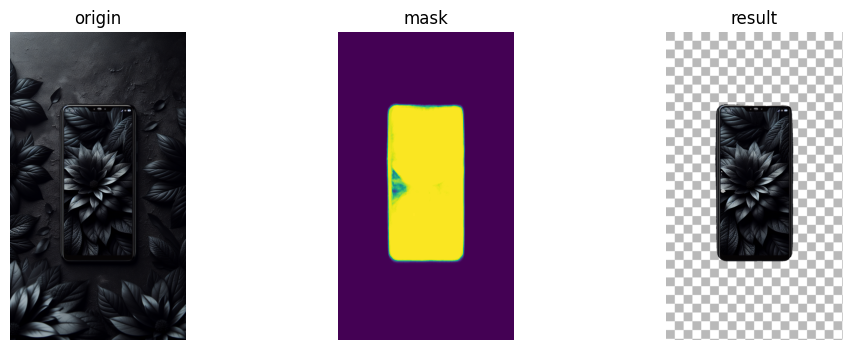

0

In [21]:
img = Image.open('leaves.png')  # PIL.Image.Image, size: (210, 280)
img = ImageOps.exif_transpose(img)

mask = s.predict(img)[0]  # PIL.Image.Image, size: (210, 280)

display_transparancy(img, mask)

In [23]:
from PIL import Image, ImageOps

# Open the image and apply EXIF-based rotation
img = Image.open('leaves.png')
img = ImageOps.exif_transpose(img)

if img.mode != 'RGBA':  
    # 确保图像格式为 RGBA
    img = img.convert('RGBA')

# 预测前景遮罩，结果为 PILImage, channel=1, 
mask = s.predict(img)[0]

if mask.mode != 'L':
    # 'L' mode: 8-bit pixels, black and white
    mask = mask.convert('L')
img.putalpha(mask)
img.save('leaves-mask.png', 'PNG')

In [25]:
from PIL import Image, ImageOps

# Open the original image and apply EXIF-based rotation
img = Image.open('leaves.png')
img = ImageOps.exif_transpose(img)

# Calculate the new size, keeping the aspect ratio
original_size = img.size
max_dimension = max(original_size)
scaling_factor = 512 / max_dimension if max_dimension > 512 else 1
new_size = (int(original_size[0] * scaling_factor), int(original_size[1] * scaling_factor))

# Resize the image if necessary
img_resized = img.resize(new_size) if scaling_factor < 1 else img
mask_resized = s.predict(img_resized)[0]  # 模型预测蒙版
mask = mask_resized.resize(original_size, Image.BILINEAR)

if img.mode != 'RGBA':
    img = img.convert('RGBA')

if mask.mode != 'L':
    mask = mask.convert('L')

img.putalpha(mask)
img.save('leaves-mask2.png', 'PNG')

In [38]:
# img2 = alpha_matting_cutout(img, mask, 253, 3, 1)

# plt.figure(figsize=(7,7))
# plt.imshow(img2)
# plt.show()

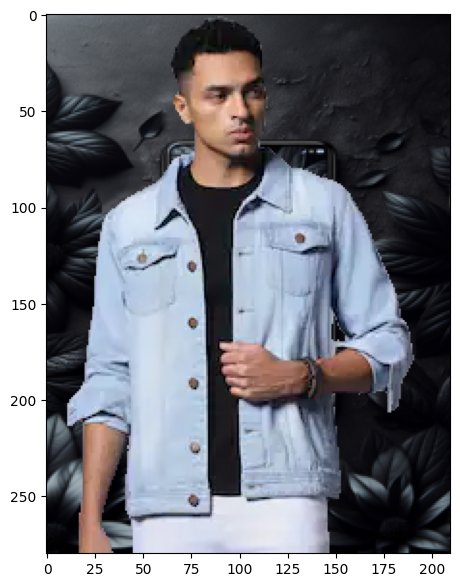

In [39]:
bg = Image.open('leaves.png').resize(img.size)
img3 = threshold_cutout(img, mask, new_bg=bg)

plt.figure(figsize=(7,7))
plt.imshow(img3)
plt.show()

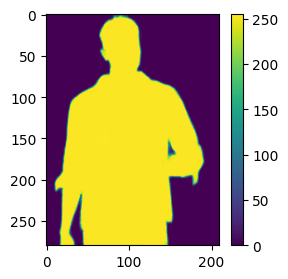

In [31]:
plt.figure(figsize=(3,3))
plt.imshow(mask)
plt.colorbar()
plt.show()

In [1]:
import torch
from transformers import AutoModelForImageSegmentation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModelForImageSegmentation.from_pretrained("model_weights/rmbg14", trust_remote_code=True).to(device).eval()

c:\Users\yafex\.conda\envs\pt22\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image
from PIL.Image import Image as PILImage
import numpy as np

def normalize(img: PILImage, mean=[0.5,0.5,0.5], std=[1.0,1.0,1.0], size=(768,768)) -> np.ndarray:
    # input size (1024, 1024) 也可以
    im = img.convert("RGB").resize(size, Image.LANCZOS)
    im_ary = np.array(im)
    im_ary = im_ary / np.max(im_ary)
    tmpImg = np.zeros((im_ary.shape[0], im_ary.shape[1], 3))
    tmpImg[:, :, 0] = (im_ary[:, :, 0] - mean[0]) / std[0]
    tmpImg[:, :, 1] = (im_ary[:, :, 1] - mean[1]) / std[1]
    tmpImg[:, :, 2] = (im_ary[:, :, 2] - mean[2]) / std[2]
    tmpImg = tmpImg.transpose((2, 0, 1))
    return np.expand_dims(tmpImg, 0).astype(np.float32)

def predict(img: PILImage) -> PILImage:
    original_size = img.size
    tmpimg = normalize(img)
    with torch.no_grad():
        mask = model(torch.tensor(tmpimg))[0][0][0, 0].numpy()
    ma, mi = np.max(mask), np.min(mask)
    mask = (mask - mi) / (ma - mi)
    mask = Image.fromarray((mask * 255).astype("uint8"), mode="L")
    mask = mask.resize(original_size, Image.LANCZOS)
    return mask

In [3]:
img = Image.open(r'C:\Users\yafex\Pictures\pics\bear.png')
img_pt = torch.tensor(normalize(img))

cpu 推理

测试图片: 32 张

batchsize=1, 运行 32 轮, 耗时 20.4s。预估 100 张图耗时 63.75s

batchsize=4, 运行 8 轮, 耗时 21.8s。预估 100 张图耗时 68.13s

batchsize=8, 运行 4 轮, 耗时 23.5s。预估 100 张图耗时 73.4s

batchsize=16, 运行 2 轮, 耗时 27.2s。预估 100 张图耗时 85s

In [24]:
# 100/40*29.6
100/32*20.4

63.74999999999999

In [5]:
import time

def test(bs=1, epochs=32):
    test_img = img_pt.repeat(bs,1,1,1)  # (1,3,768,768)
    t1 = time.time()
    for _ in range(epochs):
        with torch.no_grad():
            model(test_img)
        print('-', end='')
    t2 = time.time()
    dt = t2 - t1 
    print(f'\nbatchsize: {bs}, epochs: {epochs}, time: {dt:.3f}')
    time.sleep(10) # 防止烧坏CPU

# test(1, 32)
# test(2, 16)
test(4, 8)
# test(8, 4)
# test(16, 2)

--------
batchsize: 4, epochs: 8, time: 21.399


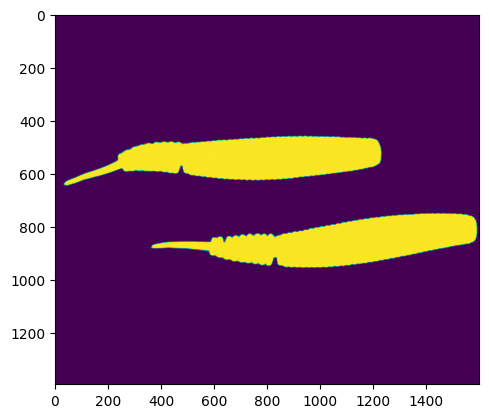

In [19]:
# prepare input
img = Image.open('DSC_0234.jpg')
mask = predict(img)

plt.imshow(mask)
plt.show()

In [10]:
tmpimg = normalize(img)
with torch.no_grad():
    masks = model(torch.tensor(tmpimg))
mask = Image.fromarray(masks[0][0][0,0].numpy())

In [22]:
mask[0][1][0,0].shape

torch.Size([768, 768])

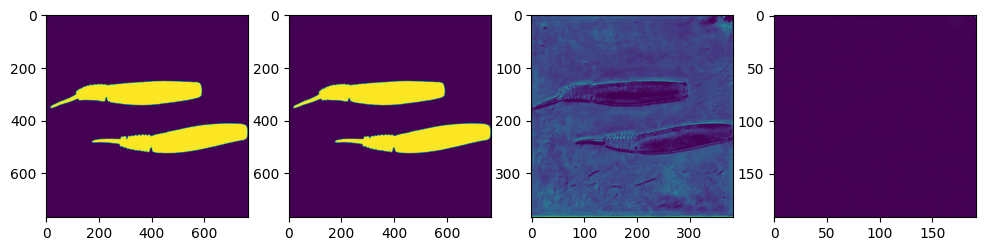

In [11]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=4)

for i in range(2):
    for j in range(2):
        idx = i*2+j
        ax[idx].imshow(masks[i][j][0,0].numpy())

In [5]:
ax[0]

array([<Axes: >, <Axes: >], dtype=object)

In [ ]:
import torch.nn.functional as F
def postprocess_image(result: torch.Tensor, im_size: list)-> np.ndarray:
    result = torch.squeeze(F.interpolate(result, size=im_size, mode='bilinear'), 0)
    ma, mi = torch.max(result), torch.min(result)
    result = (result-mi) / (ma-mi)
    im_array = (result*255).permute(1,2,0).cpu().data.numpy().astype(np.uint8)
    im_array = np.squeeze(im_array)
    return im_array



image = preprocess_image(orig_im, model_input_size).to(device)

# inference 
result=model(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0,0,0,0))
orig_image = Image.open(image_path)
no_bg_image.paste(orig_image, mask=pil_im)